# Bound the subspace dimension

In this tutorial, we will show the effect of the subspace dimension in the [self-consistent configuration recovery technique](https://arxiv.org/abs/2405.05068).

***A priori***, we do not know what is the correct subspace dimension to obtain a target level of accuracy. However, we do know that increasing the subspace dimension increases the accuracy of the method. Therefore, we can study the accuracy of the predictions as a function of the subspace dimension.

Specify the molecule and its properties.

In [1]:
from pyscf import ao2mo, tools

# Specify molecule properties
num_orbitals = 16
num_elec_a = num_elec_b = 5
open_shell = False
spin_sq = 0

# Read in molecule from disk
mf_as = tools.fcidump.to_scf("../molecules/n2_fci.txt")
hcore = mf_as.get_hcore()
eri = ao2mo.restore(1, mf_as._eri, num_orbitals)
nuclear_repulsion_energy = mf_as.mol.energy_nuc()

Parsing ../molecules/n2_fci.txt


Generate some dummy counts to proxy QPU samples.

In [2]:
import numpy as np
from qiskit_addon_sqd.counts import generate_counts_uniform

# Create a seed to control randomness throughout this workflow
rng = np.random.default_rng(2**24)

# Generate random samples
counts_dict = generate_counts_uniform(10_000, num_orbitals * 2, rand_seed=rng)

Convert the counts to a bitstring matrix

In [3]:
from qiskit_addon_sqd.counts import counts_to_arrays

# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts_dict)

Define an SQD function, which we will call in a loop with increasing batch sizes.

In [4]:
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import (
    bitstring_matrix_to_ci_strs,
    flip_orbital_occupancies,
    solve_fermion,
)
from qiskit_addon_sqd.subsampling import postselect_and_subsample


def configuration_recovery_loop(
    hcore: np.ndarray,
    eri: np.ndarray,
    num_elec_a: int,
    num_elec_b: int,
    spin_sq: float,
    iterations: int,
    n_batches: int,
    samples_per_batch: int,
    max_davidson_cycles: int,
    rng: np.random.Generator,
) -> tuple[np.ndarray, np.ndarray]:
    """Perform SQD."""
    # Self-consistent configuration recovery loop
    e_hist = np.zeros((iterations, n_batches))  # energy history
    s_hist = np.zeros((iterations, n_batches))  # spin history
    d_hist = np.zeros((iterations, n_batches))  # subspace dimension history
    occupancy_hist = np.zeros((iterations, 2 * num_orbitals))
    occupancies_bitwise = None  # orbital i corresponds to column i in bitstring matrix
    for i in range(iterations):
        print(f"Starting configuration recovery iteration {i}")
        # On the first iteration, we have no orbital occupancy information from the
        # solver, so we just post-select from the full bitstring set based on hamming weight.
        if occupancies_bitwise is None:
            bs_mat_tmp = bitstring_matrix_full
            probs_arr_tmp = probs_arr_full

        # In following iterations, we use both the occupancy info and the target hamming
        # weight to correct bitstrings.
        else:
            bs_mat_tmp, probs_arr_tmp = recover_configurations(
                bitstring_matrix_full,
                probs_arr_full,
                occupancies_bitwise,
                num_elec_a,
                num_elec_b,
                rand_seed=rng,
            )

        # Throw out samples with incorrect hamming weight and create batches of subsamples.
        batches = postselect_and_subsample(
            bs_mat_tmp,
            probs_arr_tmp,
            hamming_right=num_elec_a,
            hamming_left=num_elec_b,
            samples_per_batch=samples_per_batch,
            num_batches=n_batches,
            rand_seed=rng,
        )

        # Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
        int_e = np.zeros(n_batches)
        int_s = np.zeros(n_batches)
        int_d = np.zeros(n_batches)
        int_occs = np.zeros((n_batches, 2 * num_orbitals))
        cs = []
        for j in range(n_batches):
            ci_strs = bitstring_matrix_to_ci_strs(batches[j], open_shell=open_shell)
            int_d[j] = len(ci_strs[0]) * len(ci_strs[1])
            energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
                batches[j],
                hcore,
                eri,
                open_shell=open_shell,
                spin_sq=spin_sq,
                max_davidson=max_davidson_cycles,
            )
            energy_sci += nuclear_repulsion_energy
            int_e[j] = energy_sci
            int_s[j] = spin
            int_occs[j, :num_orbitals] = avg_occs[0]
            int_occs[j, num_orbitals:] = avg_occs[1]
            cs.append(coeffs_sci)

        # Combine batch results
        avg_occupancy = np.mean(int_occs, axis=0)
        # The occupancies from the solver should be flipped to match the bits in the bitstring matrix.
        occupancies_bitwise = flip_orbital_occupancies(avg_occupancy)

        # Track optimization history
        e_hist[i, :] = int_e
        s_hist[i, :] = int_s
        d_hist[i, :] = int_d
        occupancy_hist[i, :] = avg_occupancy

    return e_hist.flatten(), d_hist.flatten()

Call SQD with increasing batch sizes.

In [5]:
list_samples_per_batch = [50, 200, 400, 600]

# SQD options
iterations = 5

# Eigenstate solver options
n_batches = 10
max_davidson_cycles = 200

energies = []
subspace_dimensions = []

for samples_per_batch in list_samples_per_batch:
    e_hist, d_hist = configuration_recovery_loop(
        hcore,
        eri,
        num_elec_a,
        num_elec_b,
        spin_sq,
        iterations,
        n_batches,
        samples_per_batch,
        max_davidson_cycles,
        rng=rng,
    )
    energies.append(np.min(e_hist))

    index_min = np.argmin(e_hist)
    subspace_dimensions.append(d_hist[index_min])

Starting configuration recovery iteration 0
Starting configuration recovery iteration 1
Starting configuration recovery iteration 2
Starting configuration recovery iteration 3
Starting configuration recovery iteration 4
Starting configuration recovery iteration 0
Starting configuration recovery iteration 1
Starting configuration recovery iteration 2
Starting configuration recovery iteration 3
Starting configuration recovery iteration 4
Starting configuration recovery iteration 0
Starting configuration recovery iteration 1
Starting configuration recovery iteration 2
Starting configuration recovery iteration 3
Starting configuration recovery iteration 4
Starting configuration recovery iteration 0
Starting configuration recovery iteration 1
Starting configuration recovery iteration 2
Starting configuration recovery iteration 3
Starting configuration recovery iteration 4


### Visualize the results

This plot shows that increasing the subspace dimension leads to more accurate results.

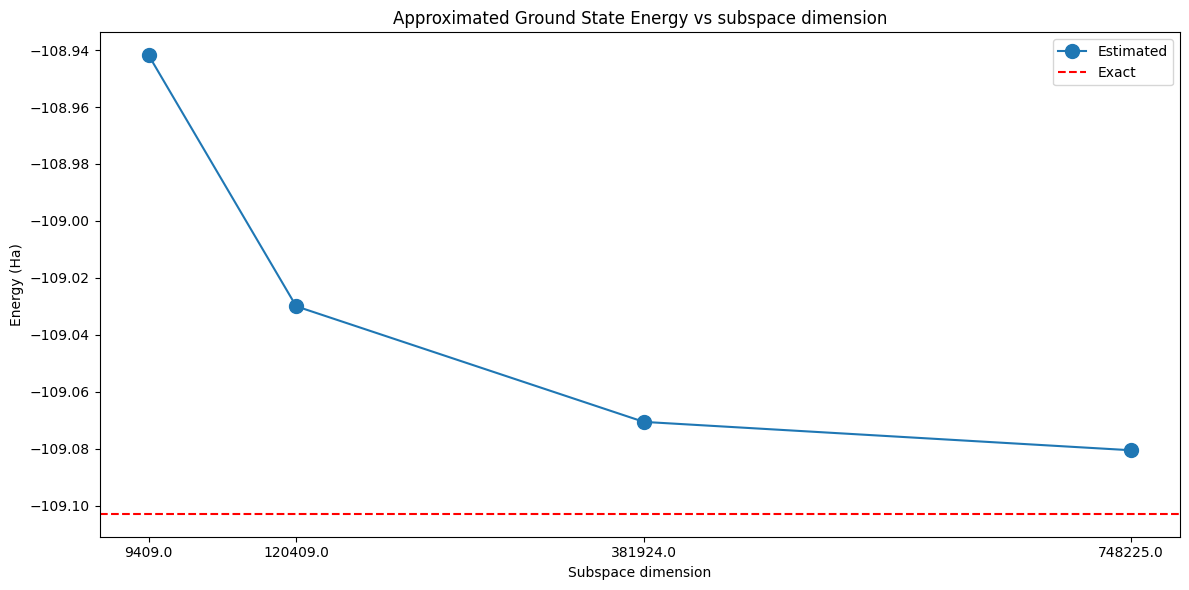

In [6]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = subspace_dimensions
n2_exact = -109.10288938
y1 = energies

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# Plot energies
axs.plot(x1, y1, marker=".", markersize=20, label="Estimated")
axs.set_xticks(x1)
axs.set_xticklabels(x1)
axs.axhline(y=n2_exact, color="red", linestyle="--", label="Exact")
axs.set_title("Approximated Ground State Energy vs subspace dimension")
axs.set_xlabel("Subspace dimension")
axs.set_ylabel("Energy (Ha)")
axs.legend()


plt.tight_layout()
plt.show()